In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89776380.73it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46094251.84it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37632998.48it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7623260.81it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz) #torch.Size([512, 1, 1, 1])

# Q. Write training loop

118it [00:17,  6.69it/s]                         


Epoch 1 of 100
Generator loss: 1.32658219, Discriminator loss: 0.90078419


118it [00:14,  8.00it/s]                         


Epoch 2 of 100
Generator loss: 2.00499682, Discriminator loss: 1.17617295


118it [00:14,  7.95it/s]                         


Epoch 3 of 100
Generator loss: 6.19980348, Discriminator loss: 0.26794707


118it [00:15,  7.72it/s]                         


Epoch 4 of 100
Generator loss: 6.73128734, Discriminator loss: 0.25844593


118it [00:16,  7.35it/s]                         


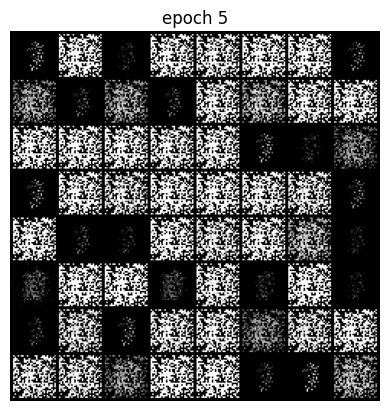

Epoch 5 of 100
Generator loss: 6.46233677, Discriminator loss: 0.46541318


118it [00:14,  7.89it/s]                         


Epoch 6 of 100
Generator loss: 6.82355870, Discriminator loss: 0.68850594


118it [00:15,  7.80it/s]                         


Epoch 7 of 100
Generator loss: 4.52353107, Discriminator loss: 0.69477325


118it [00:14,  8.01it/s]                         


Epoch 8 of 100
Generator loss: 3.46745894, Discriminator loss: 0.82128001


118it [00:14,  8.02it/s]                         


Epoch 9 of 100
Generator loss: 4.43224665, Discriminator loss: 0.70039035


118it [00:14,  7.93it/s]                         


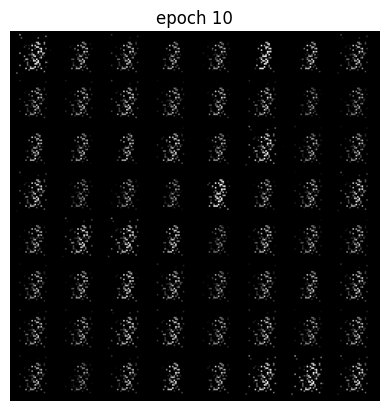

Epoch 10 of 100
Generator loss: 3.87179369, Discriminator loss: 0.78227791


118it [00:15,  7.81it/s]                         


Epoch 11 of 100
Generator loss: 3.43983763, Discriminator loss: 0.90921691


118it [00:15,  7.86it/s]                         


Epoch 12 of 100
Generator loss: 2.00721814, Discriminator loss: 1.13355389


118it [00:14,  7.91it/s]                         


Epoch 13 of 100
Generator loss: 2.31732918, Discriminator loss: 0.99821526


118it [00:15,  7.65it/s]                         


Epoch 14 of 100
Generator loss: 1.76706277, Discriminator loss: 1.00889358


118it [00:15,  7.71it/s]                         


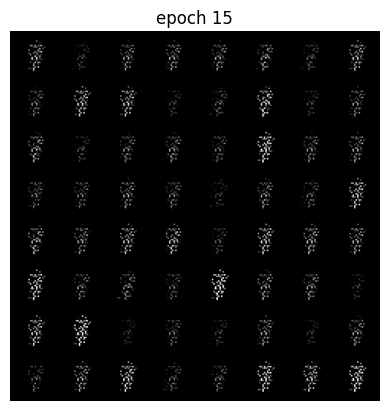

Epoch 15 of 100
Generator loss: 3.99274222, Discriminator loss: 0.59048236


118it [00:15,  7.86it/s]                         


Epoch 16 of 100
Generator loss: 2.20406904, Discriminator loss: 0.89312410


118it [00:15,  7.75it/s]                         


Epoch 17 of 100
Generator loss: 2.18530755, Discriminator loss: 0.89054705


118it [00:15,  7.83it/s]                         


Epoch 18 of 100
Generator loss: 2.28325959, Discriminator loss: 0.82631744


118it [00:15,  7.67it/s]                         


Epoch 19 of 100
Generator loss: 2.63531424, Discriminator loss: 0.59989385


118it [00:15,  7.79it/s]                         


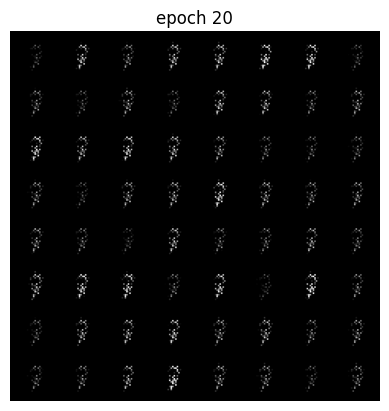

Epoch 20 of 100
Generator loss: 2.57614934, Discriminator loss: 0.59312104


118it [00:15,  7.86it/s]                         


Epoch 21 of 100
Generator loss: 2.38819978, Discriminator loss: 0.63657267


118it [00:15,  7.76it/s]                         


Epoch 22 of 100
Generator loss: 3.29421138, Discriminator loss: 0.53510387


118it [00:15,  7.68it/s]                         


Epoch 23 of 100
Generator loss: 2.69519125, Discriminator loss: 0.51731433


118it [00:15,  7.58it/s]                         


Epoch 24 of 100
Generator loss: 2.21512274, Discriminator loss: 0.55427871


118it [00:15,  7.44it/s]                         


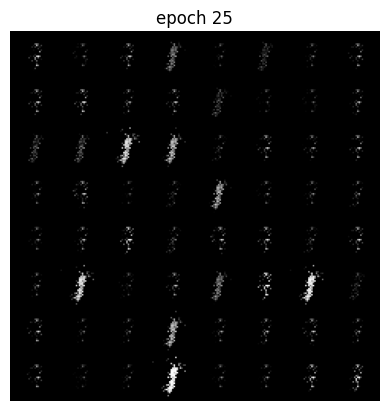

Epoch 25 of 100
Generator loss: 2.76168654, Discriminator loss: 0.50170655


118it [00:15,  7.86it/s]                         


Epoch 26 of 100
Generator loss: 2.48298247, Discriminator loss: 0.47068845


118it [00:14,  7.90it/s]                         


Epoch 27 of 100
Generator loss: 3.11749216, Discriminator loss: 0.39492118


118it [00:15,  7.84it/s]                         


Epoch 28 of 100
Generator loss: 3.05426194, Discriminator loss: 0.37618830


118it [00:15,  7.84it/s]                         


Epoch 29 of 100
Generator loss: 3.34165652, Discriminator loss: 0.39216811


118it [00:15,  7.80it/s]                         


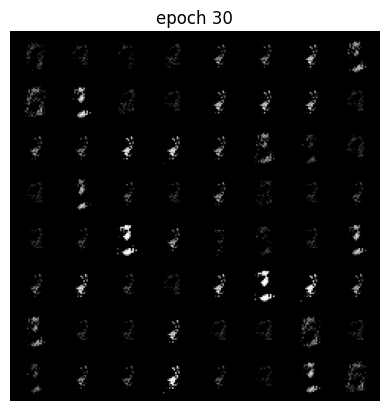

Epoch 30 of 100
Generator loss: 3.24447893, Discriminator loss: 0.40166895


118it [00:15,  7.81it/s]                         


Epoch 31 of 100
Generator loss: 2.87715831, Discriminator loss: 0.55336958


118it [00:15,  7.73it/s]                         


Epoch 32 of 100
Generator loss: 2.73599196, Discriminator loss: 0.49197500


118it [00:15,  7.73it/s]                         


Epoch 33 of 100
Generator loss: 2.88469914, Discriminator loss: 0.43309040


118it [00:15,  7.56it/s]                         


Epoch 34 of 100
Generator loss: 3.46948768, Discriminator loss: 0.33904190


118it [00:15,  7.75it/s]                         


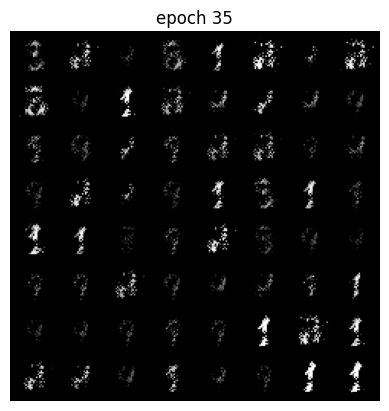

Epoch 35 of 100
Generator loss: 3.17227069, Discriminator loss: 0.44043642


118it [00:15,  7.72it/s]                         


Epoch 36 of 100
Generator loss: 3.53866641, Discriminator loss: 0.35567665


118it [00:15,  7.72it/s]                         


Epoch 37 of 100
Generator loss: 3.55758773, Discriminator loss: 0.43345846


118it [00:15,  7.67it/s]                         


Epoch 38 of 100
Generator loss: 2.88362734, Discriminator loss: 0.53734917


118it [00:15,  7.72it/s]                         


Epoch 39 of 100
Generator loss: 3.06593713, Discriminator loss: 0.42182004


118it [00:15,  7.82it/s]                         


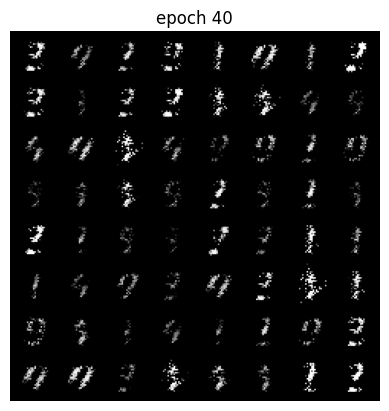

Epoch 40 of 100
Generator loss: 3.58561388, Discriminator loss: 0.37754949


118it [00:15,  7.59it/s]                         


Epoch 41 of 100
Generator loss: 3.16278671, Discriminator loss: 0.51838569


118it [00:15,  7.75it/s]                         


Epoch 42 of 100
Generator loss: 2.85406772, Discriminator loss: 0.47403014


118it [00:15,  7.60it/s]                         


Epoch 43 of 100
Generator loss: 3.28559676, Discriminator loss: 0.40680134


118it [00:15,  7.60it/s]                         


Epoch 44 of 100
Generator loss: 3.38074749, Discriminator loss: 0.43542454


118it [00:16,  7.37it/s]                         


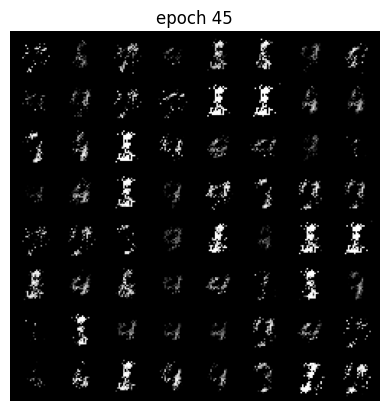

Epoch 45 of 100
Generator loss: 3.43029788, Discriminator loss: 0.41478818


118it [00:15,  7.64it/s]                         


Epoch 46 of 100
Generator loss: 3.42411589, Discriminator loss: 0.42154622


118it [00:15,  7.71it/s]                         


Epoch 47 of 100
Generator loss: 3.26089579, Discriminator loss: 0.42064353


118it [00:15,  7.83it/s]                         


Epoch 48 of 100
Generator loss: 3.25547659, Discriminator loss: 0.50839116


118it [00:15,  7.70it/s]                         


Epoch 49 of 100
Generator loss: 3.08486035, Discriminator loss: 0.49803825


118it [00:15,  7.80it/s]                         


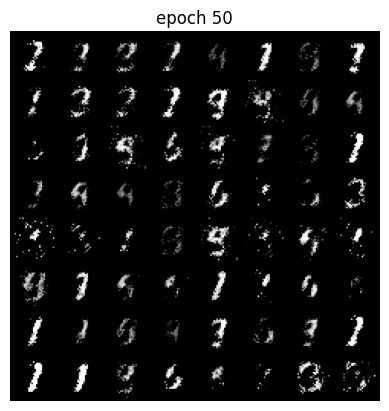

Epoch 50 of 100
Generator loss: 2.61478250, Discriminator loss: 0.54925845


118it [00:15,  7.63it/s]                         


Epoch 51 of 100
Generator loss: 3.15592568, Discriminator loss: 0.46957358


118it [00:15,  7.59it/s]                         


Epoch 52 of 100
Generator loss: 2.89124295, Discriminator loss: 0.53420300


118it [00:15,  7.55it/s]                         


Epoch 53 of 100
Generator loss: 2.87283931, Discriminator loss: 0.50727805


118it [00:15,  7.45it/s]                         


Epoch 54 of 100
Generator loss: 2.95392168, Discriminator loss: 0.51265158


118it [00:15,  7.51it/s]                         


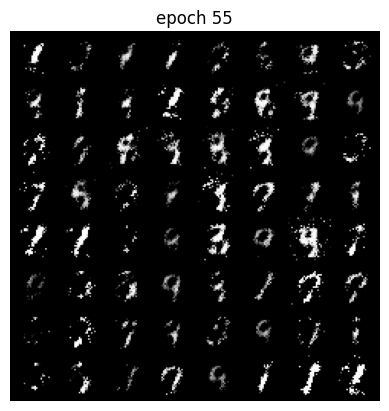

Epoch 55 of 100
Generator loss: 2.97701062, Discriminator loss: 0.49853668


118it [00:15,  7.76it/s]                         


Epoch 56 of 100
Generator loss: 2.97000193, Discriminator loss: 0.48734986


118it [00:15,  7.68it/s]                         


Epoch 57 of 100
Generator loss: 2.98521028, Discriminator loss: 0.49828388


118it [00:15,  7.73it/s]                         


Epoch 58 of 100
Generator loss: 3.16204942, Discriminator loss: 0.44116203


118it [00:15,  7.63it/s]                         


Epoch 59 of 100
Generator loss: 3.05286233, Discriminator loss: 0.50667743


118it [00:15,  7.71it/s]                         


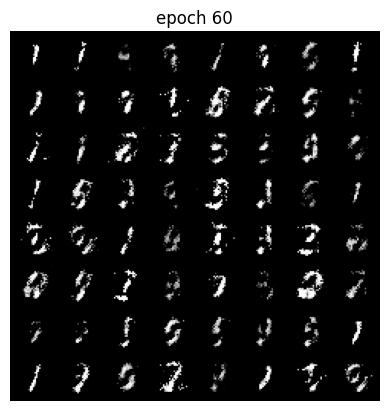

Epoch 60 of 100
Generator loss: 2.74409531, Discriminator loss: 0.61716843


118it [00:15,  7.68it/s]                         


Epoch 61 of 100
Generator loss: 3.05227648, Discriminator loss: 0.51898765


118it [00:15,  7.69it/s]                         


Epoch 62 of 100
Generator loss: 3.02714067, Discriminator loss: 0.47700891


118it [00:16,  7.31it/s]                         


Epoch 63 of 100
Generator loss: 3.00324542, Discriminator loss: 0.52331503


118it [00:15,  7.38it/s]                         


Epoch 64 of 100
Generator loss: 2.83744613, Discriminator loss: 0.54509197


118it [00:15,  7.53it/s]                         


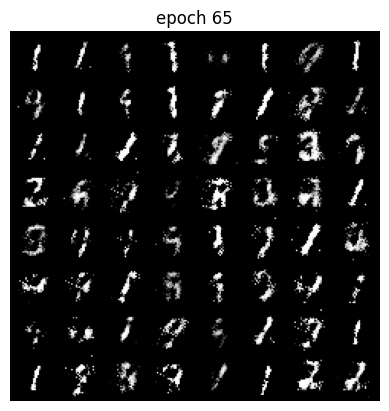

Epoch 65 of 100
Generator loss: 2.83664248, Discriminator loss: 0.59492699


118it [00:15,  7.53it/s]                         


Epoch 66 of 100
Generator loss: 2.61976887, Discriminator loss: 0.60754468


118it [00:15,  7.59it/s]                         


Epoch 67 of 100
Generator loss: 2.63913103, Discriminator loss: 0.57504536


118it [00:15,  7.61it/s]                         


Epoch 68 of 100
Generator loss: 2.73719433, Discriminator loss: 0.55707241


118it [00:15,  7.55it/s]                         


Epoch 69 of 100
Generator loss: 2.67555238, Discriminator loss: 0.58948476


118it [00:15,  7.70it/s]                         


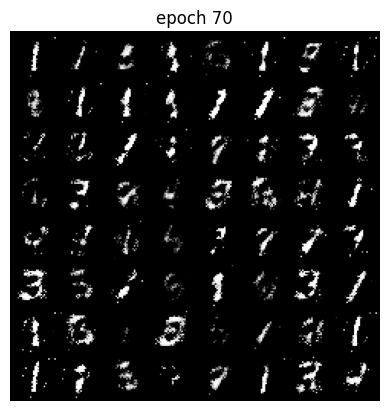

Epoch 70 of 100
Generator loss: 2.82000228, Discriminator loss: 0.58651376


118it [00:15,  7.59it/s]                         


Epoch 71 of 100
Generator loss: 2.70902724, Discriminator loss: 0.59118146


118it [00:15,  7.53it/s]                         


Epoch 72 of 100
Generator loss: 2.49740714, Discriminator loss: 0.60637638


118it [00:16,  7.34it/s]                         


Epoch 73 of 100
Generator loss: 2.37764470, Discriminator loss: 0.62599384


118it [00:15,  7.46it/s]                         


Epoch 74 of 100
Generator loss: 2.39112375, Discriminator loss: 0.60252616


118it [00:15,  7.61it/s]                         


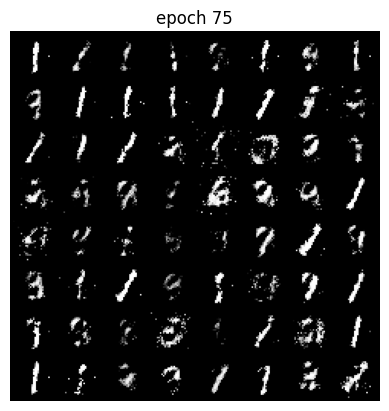

Epoch 75 of 100
Generator loss: 2.54366900, Discriminator loss: 0.61927942


118it [00:15,  7.66it/s]                         


Epoch 76 of 100
Generator loss: 2.28181297, Discriminator loss: 0.64937040


118it [00:15,  7.62it/s]                         


Epoch 77 of 100
Generator loss: 2.47818676, Discriminator loss: 0.63041371


118it [00:15,  7.65it/s]                         


Epoch 78 of 100
Generator loss: 2.34174711, Discriminator loss: 0.66728188


118it [00:15,  7.66it/s]                         


Epoch 79 of 100
Generator loss: 2.42543039, Discriminator loss: 0.63507391


118it [00:15,  7.51it/s]                         


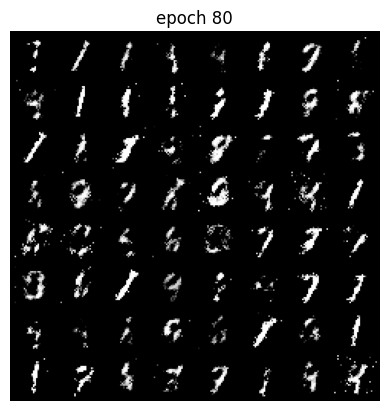

Epoch 80 of 100
Generator loss: 2.45935234, Discriminator loss: 0.63778159


118it [00:16,  7.30it/s]                         


Epoch 81 of 100
Generator loss: 2.48141382, Discriminator loss: 0.63857263


118it [00:15,  7.38it/s]                         


Epoch 82 of 100
Generator loss: 2.36206000, Discriminator loss: 0.63674690


118it [00:15,  7.64it/s]                         


Epoch 83 of 100
Generator loss: 2.50267186, Discriminator loss: 0.60299298


118it [00:15,  7.50it/s]                         


Epoch 84 of 100
Generator loss: 2.28860247, Discriminator loss: 0.66510385


118it [00:15,  7.41it/s]                         


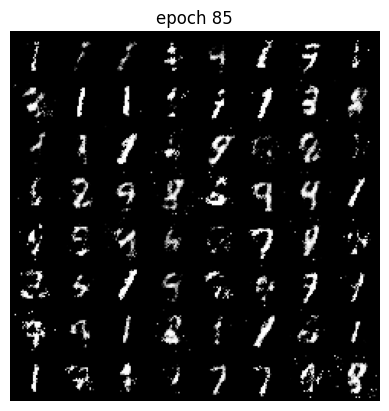

Epoch 85 of 100
Generator loss: 2.32185240, Discriminator loss: 0.67818637


118it [00:15,  7.60it/s]                         


Epoch 86 of 100
Generator loss: 2.42153785, Discriminator loss: 0.68203775


118it [00:15,  7.61it/s]                         


Epoch 87 of 100
Generator loss: 2.29285706, Discriminator loss: 0.68065612


118it [00:15,  7.64it/s]                         


Epoch 88 of 100
Generator loss: 2.20086971, Discriminator loss: 0.70460734


118it [00:15,  7.68it/s]                         


Epoch 89 of 100
Generator loss: 2.19092733, Discriminator loss: 0.73851276


118it [00:16,  7.35it/s]                         


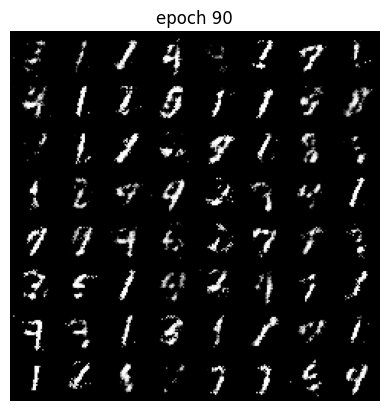

Epoch 90 of 100
Generator loss: 2.29591486, Discriminator loss: 0.68378670


118it [00:16,  7.32it/s]                         


Epoch 91 of 100
Generator loss: 2.13786332, Discriminator loss: 0.73604403


118it [00:15,  7.63it/s]                         


Epoch 92 of 100
Generator loss: 2.25418190, Discriminator loss: 0.70256564


118it [00:15,  7.59it/s]                         


Epoch 93 of 100
Generator loss: 2.21978241, Discriminator loss: 0.75097992


118it [00:15,  7.57it/s]                         


Epoch 94 of 100
Generator loss: 2.25166172, Discriminator loss: 0.66741655


118it [00:15,  7.44it/s]                         


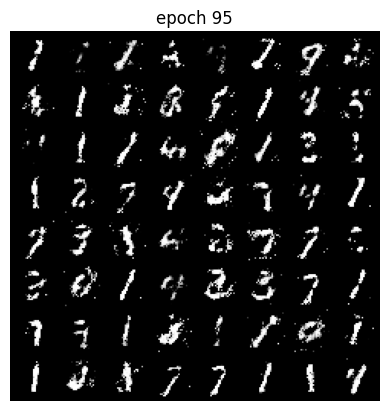

Epoch 95 of 100
Generator loss: 2.17329087, Discriminator loss: 0.72627305


118it [00:15,  7.44it/s]                         


Epoch 96 of 100
Generator loss: 2.21278638, Discriminator loss: 0.74715800


118it [00:15,  7.64it/s]                         


Epoch 97 of 100
Generator loss: 2.08589536, Discriminator loss: 0.76304096


118it [00:15,  7.54it/s]                         


Epoch 98 of 100
Generator loss: 2.11987170, Discriminator loss: 0.75461469


118it [00:15,  7.51it/s]                         


Epoch 99 of 100
Generator loss: 2.09533161, Discriminator loss: 0.75766128


118it [00:16,  7.33it/s]                         


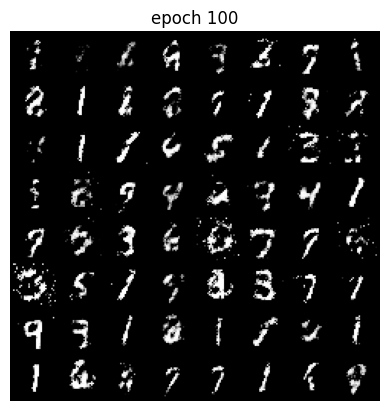

Epoch 100 of 100
Generator loss: 1.89095329, Discriminator loss: 0.78686788


In [14]:
from torch.nn.modules.distance import PairwiseDistance
torch.manual_seed(7777)

def generator_loss(output, true_label):
  return criterion(output,true_label)

def discriminator_loss(output, true_label):
  return criterion(output,true_label)


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########
        # Update discriminators
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        tr_noise = create_noise(len(real_cpu), nz)
        generated = generator(tr_noise)
        real_output = discriminator(real_cpu)


        label = label_real(len(real_cpu))
        errD_real = discriminator_loss(real_output, label)
        errD_real.backward()

        #train w fake

        gen_output = discriminator(generated)
        errD_fake = generator_loss(gen_output,label_fake(len(generated)))
        errD_fake.backward()
        errD = errD_real + errD_fake
        optim_d.step()

        loss_d += errD.item()

        #Update generators
        generator.zero_grad()
        tr_noise2 = create_noise(len(real_cpu), nz)
        fake2 = generator(tr_noise2)
        gen_output2 = discriminator(fake2)
        label2 = label_real(len(real_cpu))
        errG = criterion(gen_output2,label2)
        errG.backward()
        optim_g.step()

        loss_g += errG.item()
        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
# Create a tensor and a matrix
tensor = np.random.rand(512, 1)  # Example 512x1 tensor
matrix = np.random.rand(128, 256)  # Example 128x256 matrix

# Reshape the tensor to match the size for multiplication
reshaped_tensor = tensor.reshape(4, 128)

# Perform matrix multiplication
result = np.dot(reshaped_tensor, matrix)

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

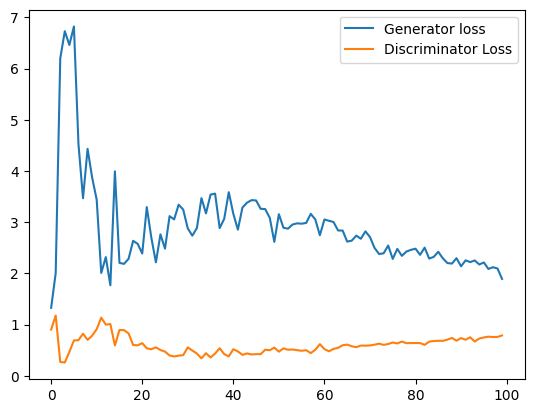

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')